# Job recommendation system

##### Work FLow 
1. Which country, state and city are popular among job creator?
2. Which country, state and city are popular among job seekers?
3. Recommend similar jobs based on the jobs title, description
4. Recommend jobs based on similar user profiles

## Import dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import warnings; warnings.simplefilter('ignore')

In [2]:
! pip install nltk
! pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
# from surprise import Reader, Dataset, SVD, evaluate

## Load dataset

In [4]:
import os

# Specify the directory
directory = './input_data/'

# List all .tsv files in the directory
tsv_files = [f for f in os.listdir(directory) if f.endswith('.tsv')]

print(tsv_files)


['apps.tsv', 'jobs.tsv', 'test_users.tsv', 'users.tsv', 'user_history.tsv']


In [5]:
apps = pd.read_csv('./input_data/apps.tsv', delimiter='\t',encoding='utf-8')
user_history = pd.read_csv('./input_data/user_history.tsv', delimiter='\t',encoding='utf-8')
jobs = pd.read_csv('./input_data/jobs.tsv', delimiter='\t',encoding='utf-8',  on_bad_lines='skip')
users = pd.read_csv('./input_data/users.tsv' ,delimiter='\t',encoding='utf-8')
test_users = pd.read_csv('./input_data/test_users.tsv', delimiter='\t',encoding='utf-8')

In [6]:
apps.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [7]:
apps.columns

Index(['UserID', 'WindowID', 'Split', 'ApplicationDate', 'JobID'], dtype='object')

In [8]:
apps.shape

(1603111, 5)

In [9]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603111 entries, 0 to 1603110
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   UserID           1603111 non-null  int64 
 1   WindowID         1603111 non-null  int64 
 2   Split            1603111 non-null  object
 3   ApplicationDate  1603111 non-null  object
 4   JobID            1603111 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 61.2+ MB


In [10]:
user_history.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [11]:
user_history.columns

Index(['UserID', 'WindowID', 'Split', 'Sequence', 'JobTitle'], dtype='object')

In [12]:
user_history.shape

(1753901, 5)

In [13]:
user_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753901 entries, 0 to 1753900
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   UserID    int64 
 1   WindowID  int64 
 2   Split     object
 3   Sequence  int64 
 4   JobTitle  object
dtypes: int64(3), object(2)
memory usage: 66.9+ MB


In [14]:
jobs.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


In [15]:
jobs.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')

In [16]:
jobs.shape

(1091923, 11)

In [17]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091923 entries, 0 to 1091922
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   JobID         1091923 non-null  int64 
 1   WindowID      1091923 non-null  int64 
 2   Title         1091916 non-null  object
 3   Description   1091706 non-null  object
 4   Requirements  1050478 non-null  object
 5   City          1091921 non-null  object
 6   State         1091922 non-null  object
 7   Country       1091920 non-null  object
 8   Zip5          685724 non-null   object
 9   StartDate     1091923 non-null  object
 10  EndDate       1091914 non-null  object
dtypes: int64(2), object(9)
memory usage: 91.6+ MB


In [18]:
users.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [19]:
users.columns

Index(['UserID', 'WindowID', 'Split', 'City', 'State', 'Country', 'ZipCode',
       'DegreeType', 'Major', 'GraduationDate', 'WorkHistoryCount',
       'TotalYearsExperience', 'CurrentlyEmployed', 'ManagedOthers',
       'ManagedHowMany'],
      dtype='object')

In [20]:
users.shape

(389708, 15)

In [21]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389708 entries, 0 to 389707
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   UserID                389708 non-null  int64  
 1   WindowID              389708 non-null  int64  
 2   Split                 389708 non-null  object 
 3   City                  389708 non-null  object 
 4   State                 389218 non-null  object 
 5   Country               389708 non-null  object 
 6   ZipCode               387974 non-null  object 
 7   DegreeType            289555 non-null  object 
 8   Major                 292405 non-null  object 
 9   GraduationDate        269477 non-null  object 
 10  WorkHistoryCount      389708 non-null  int64  
 11  TotalYearsExperience  375528 non-null  float64
 12  CurrentlyEmployed     347632 non-null  object 
 13  ManagedOthers         389708 non-null  object 
 14  ManagedHowMany        389708 non-null  int64  
dtype

In [22]:
test_users.head()

,UserID,WindowID
0,767,1
1,769,1
2,861,1
3,1006,1
4,1192,1


In [23]:
test_users.columns

Index(['UserID', 'WindowID'], dtype='object')

In [24]:
test_users.shape

(22838, 2)

In [25]:
test_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22838 entries, 0 to 22837
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   UserID    22838 non-null  int64
 1   WindowID  22838 non-null  int64
dtypes: int64(2)
memory usage: 357.0 KB


## Exploratory Data Analysis (EDA) and Pre-processing

### Split training and testing data based on column 'split'

In [26]:
print ('app : ' , apps['Split'].unique())
print ('user_history : ' , apps['Split'].unique())
print ('users : ' , apps['Split'].unique())

app :  ['Train' 'Test']
user_history :  ['Train' 'Test']
users :  ['Train' 'Test']


In [27]:
apps_training = apps.loc[apps['Split'] == 'Train']

In [28]:
apps_training.shape

(1417514, 5)

In [29]:
apps_training["Split"].unique()

array(['Train'], dtype=object)

In [30]:
apps_training.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [31]:
apps_testing = apps.loc[apps['Split'] == 'Test']

In [32]:
apps_testing.shape

(185597, 5)

In [33]:
apps_testing["Split"].unique()

array(['Test'], dtype=object)

In [34]:
apps_testing.head()

,UserID,WindowID,Split,ApplicationDate,JobID
126,767,1,Test,2012-04-01 14:37:20.023,85377
127,769,1,Test,2012-04-16 22:36:52.48,853328
128,769,1,Test,2012-04-09 18:59:28.193,86106
129,769,1,Test,2012-04-09 18:59:31.127,327571
130,769,1,Test,2012-04-08 21:29:11.993,119161


In [35]:
user_history['Split'].unique()

array(['Train', 'Test'], dtype=object)

In [36]:
user_history_training = user_history.loc[user_history['Split'] =='Train']

In [37]:
user_history_training.shape

(1652513, 5)

In [38]:
user_history_training.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [39]:
user_history_testing = user_history.loc[user_history['Split'] =='Test']

In [40]:
user_history_testing.shape

(101388, 5)

In [41]:
user_history_testing.head()

,UserID,WindowID,Split,Sequence,JobTitle
144,767,1,Test,1,Claims Adjuster
145,767,1,Test,2,Professional Baseball Player
146,767,1,Test,3,Professional Baseball Player
147,767,1,Test,4,Professional Baseball Player
148,767,1,Test,5,Professional Baseball Player


In [42]:
users_training = users.loc[users['Split']=='Train']

In [43]:
users_training.shape

(366870, 15)

In [44]:
users_training.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [45]:
users_testing = users.loc[users['Split']=='Test']

In [46]:
users_testing.shape

(22838, 15)

In [47]:
users_testing.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
31,767,1,Test,Murrieta,CA,US,92562,Bachelor's,University Studies/Business,2008-05-01 00:00:00,5,16.0,No,No,0
32,769,1,Test,Roselle,IL,US,60172,Bachelor's,Radio-Television,2011-05-01 00:00:00,5,5.0,Yes,No,0
33,861,1,Test,Morris,IL,US,60450,High School,General Studies,1989-05-01 00:00:00,7,21.0,NaN,No,0
38,1006,1,Test,West Chester,PA,US,19382,High School,Not Applicable,2008-06-01 00:00:00,3,6.0,Yes,No,0
44,1192,1,Test,Cincinnati,OH,US,45255,Bachelor's,Marketing,NaN,5,6.0,Yes,No,0


### List down all training data records 

In [48]:
apps_training.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [49]:
user_history_training.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [50]:
users_training.head(5).transpose()

,0,1,2,3,4
UserID,47,72,80,98,123
WindowID,1,1,1,1,1
Split,Train,Train,Train,Train,Train
City,Paramount,La Mesa,Williamstown,Astoria,Baton Rouge
State,CA,CA,NJ,NY,LA
Country,US,US,US,US,US
ZipCode,90723,91941,08094,11105,70808
DegreeType,High School,Master's,High School,Master's,Bachelor's
Major,NaN,Anthropology,Not Applicable,Journalism,Agricultural Business
GraduationDate,1999-06-01 00:00:00,2011-01-01 00:00:00,1985-06-01 00:00:00,2007-05-01 00:00:00,2011-05-01 00:00:00


In [51]:
jobs.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


### EDA for job openings based on their location information

In [52]:
jobs.groupby(['City','State','Country']).size().reset_index(name='Locationwise')

,City,State,Country,Locationwise
0,&#60;&#47;b&#62; Brno &#60;b&#62;,,CZ,1
1,&#60;&#47;b&#62; Praha &#60;b&#62;,,CZ,1
2,- Any,,CZ,13
3,29 Palms,CA,US,1
4,<,,HU,1
...,...,...,...,...
15689,puebla,,MX,1
15690,san jose,,BJ,6
15691,san jose,,UA,1
15692,seoul,,KR,2


* Here data attribute state, there are some empty values.

In [53]:
jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',ascending=False).head()

,Country,Locationwise
59,US,1090462
4,AF,560
19,CZ,193
40,MX,93
52,TR,81


In [54]:
Country_wise_job = jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',ascending=False)

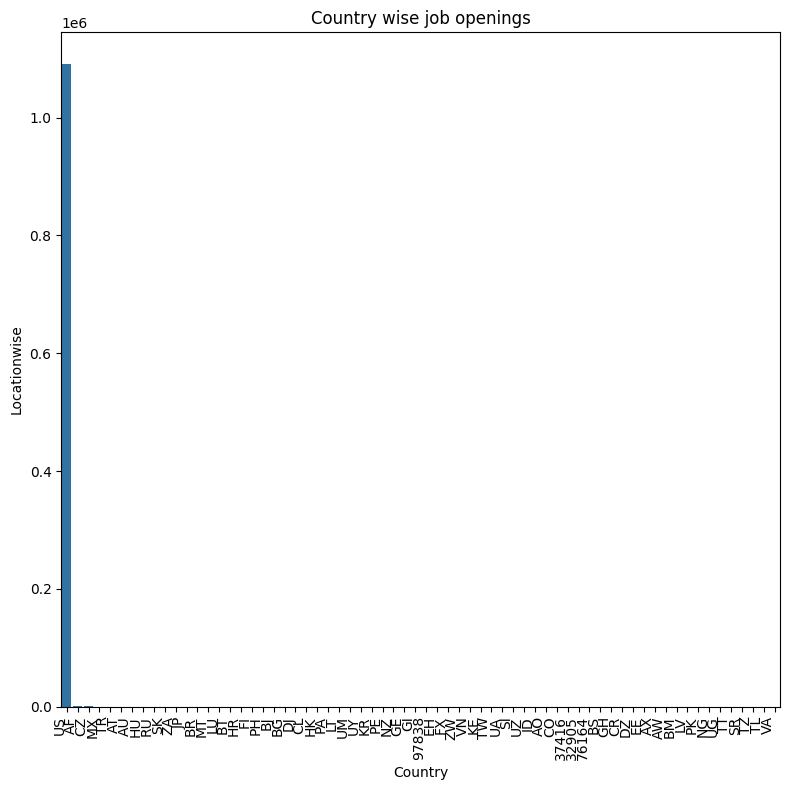

In [55]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x="Country", y="Locationwise", data=Country_wise_job)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Country wise job openings')
plt.tight_layout()
plt.show()

##### pre-processing
* Considering only US region for building this recommendation system
* Removing data records where state is blank or state data attribute is having numerical value.

In [56]:
jobs_US = jobs.loc[jobs['Country']=='US']

In [57]:
jobs_US[['City','State','Country']]

,City,State,Country
0,Washington,DC,US
1,Charlotte,NC,US
2,Winter Park,FL,US
3,Orlando,FL,US
4,Orlando,FL,US
...,...,...,...
1091918,Amsterdam,NY,US
1091919,Birmingham,AL,US
1091920,Carthage,MS,US
1091921,Warren,MI,US


In [58]:
jobs_US.groupby(['City','State','Country']).size().reset_index(name='Locationwise').sort_values('Locationwise', ascending=False).head()

,City,State,Country,Locationwise
6601,Houston,TX,US,19306
9835,New York,NY,US,18395
2651,Chicago,IL,US,17806
3475,Dallas,TX,US,13139
610,Atlanta,GA,US,12352


##### State-wise analysis of job openings

In [59]:
State_wise_job_US = jobs_US.groupby(['State']).size().reset_index(name='Locationwise').sort_values('Locationwise',ascending=False)

In [60]:
State_wise_job_US.head()

,State,Locationwise
5,CA,109630
48,TX,98071
10,FL,71024
16,IL,58743
38,NY,53998


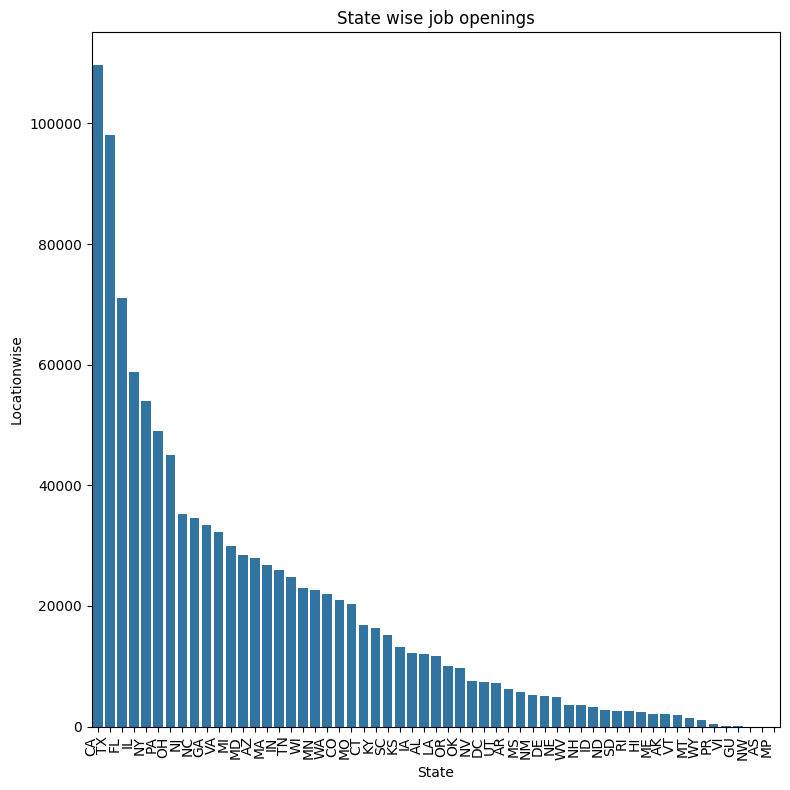

In [61]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x="State", y="Locationwise",data=State_wise_job_US)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job openings')
plt.tight_layout()
plt.show()

##### City-wise analysis of job openings

In [62]:
jobs_US.groupby(['City']).size().reset_index(name='Locationwise').sort_values('Locationwise',ascending=False)

,City,Locationwise
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365
...,...,...
8501,Saint Croix,1
4132,Hampton Springs,1
4135,Hamtown,1
4138,Hanalei,1


In [63]:
City_wise_location = jobs_US.groupby(['City']).size().reset_index(name='Locationwise').sort_values('Locationwise',ascending=False)

In [64]:
City_wise_location_th = City_wise_location.loc[City_wise_location['Locationwise']>=12]

In [65]:
City_wise_location_th

,City,Locationwise
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365
...,...,...
10676,Willows,12
3572,Fredericktown,12
10768,Woodbine,12
2890,Eastlake,12


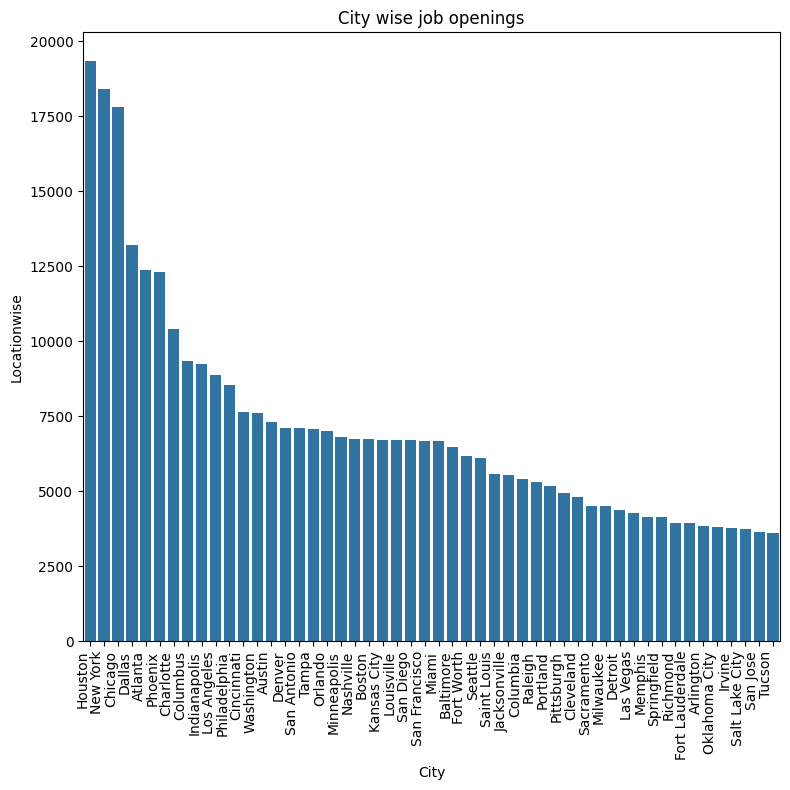

In [66]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x="City", y="Locationwise",data=City_wise_location_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('City wise job openings')
plt.tight_layout()
plt.show()

#### Insights:
* state-wise analysis : CA, TX, FL, IL and NY are having more job opening than other state 
* city-wise analysis : Houston, New York, Chicago, Dallas, Atlanta and Phoenix are having more jobs than other cities

### EDA for User profiles based on their location information

In [67]:
users_training.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',ascending=False).head()

,Country,Locationwise
105,US,365740
47,IN,236
18,CA,108
81,PH,59
82,PK,59


In [68]:
user_training_US = users_training.loc[users_training['Country']=='US']

In [69]:
user_training_US.shape

(365740, 15)

##### State-wise analysis of User profiles

In [70]:
user_training_US.groupby(['State']).size().reset_index(name='Locationwise_state').sort_values('Locationwise_state',ascending=False)

,State,Locationwise_state
11,FL,40381
47,TX,33260
6,CA,31141
17,IL,22557
37,NY,19299
41,PA,16206
12,GA,15003
34,NJ,14887
38,OH,14750
30,NC,13887


In [71]:
user_training_US_state_wise = user_training_US.groupby(['State']).size().reset_index(name='Locationwise_state').sort_values('Locationwise_state',ascending=False)

In [72]:
user_training_US_th = user_training_US_state_wise.loc[user_training_US_state_wise['Locationwise_state']>=12]

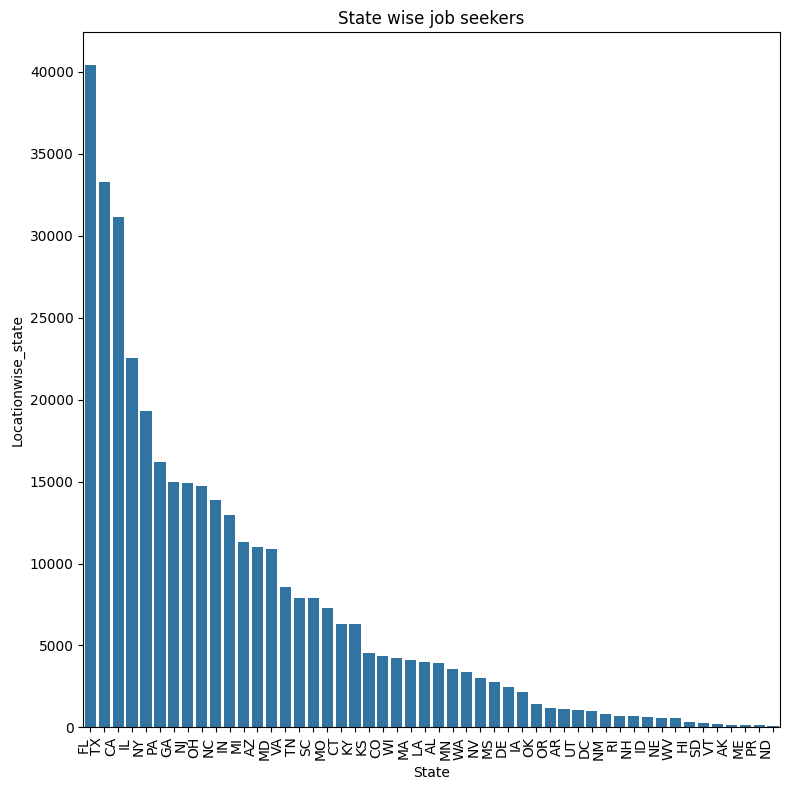

In [73]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x="State", y="Locationwise_state",data=user_training_US_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()

##### City-wise analysis of User profiles

In [74]:
user_training_US.groupby(['City']).size().reset_index(name='Locationwise_city').sort_values('Locationwise_city',ascending=False)

,City,Locationwise_city
1528,Chicago,6964
4066,Houston,5487
4177,Indianapolis,4450
5604,Miami,4359
6965,Philadelphia,4347
...,...,...
10019,Zieglerville,1
10022,Zionhill,1
10025,Zumbrota,1
10026,Zuni,1


In [75]:
user_training_US_city_wise = user_training_US.groupby(['City']).size().reset_index(name='Locationwise_city').sort_values('Locationwise_city',ascending=False)

In [76]:
user_training_US_City_th = user_training_US_city_wise.loc[user_training_US_city_wise['Locationwise_city']>=12]

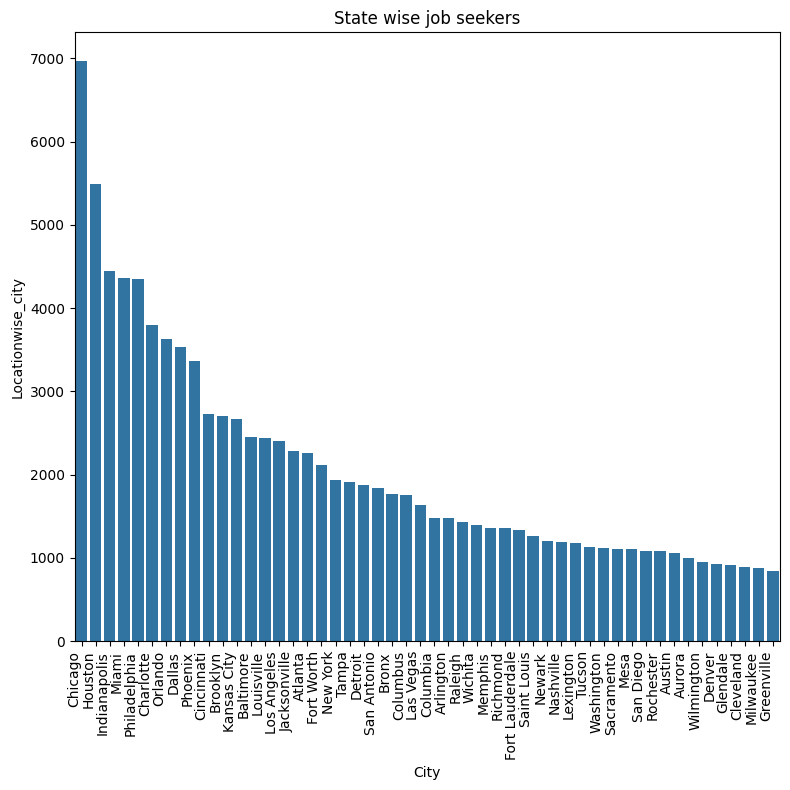

In [77]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x="City", y="Locationwise_city",data=user_training_US_City_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()

#### Insights:
* state-wise analysis : FL, TX, CA, IL and NY are having more job seeker than other state 
* city-wise analysis : Chicago,Houston, Indianapolis, Miami , Philadelphia and Charlotte are having more job seeker than other cities

## Content-Based Filtering

In [78]:
jobs_US.shape

(1090462, 11)

In [79]:
jobs_US.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')

In [80]:
jobs_US.head().transpose()

,0,1,2,3,4
JobID,1,4,7,8,9
WindowID,1,1,1,1,1
Title,Security Engineer/Technical Lead,SAP Business Analyst / WM,P/T HUMAN RESOURCES ASSISTANT,Route Delivery Drivers,Housekeeping
Description,<p>Security Clearance Required:&nbsp; Top Secr...,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,CITY BEVERAGES Come to work for the best in th...,I make sure every part of their day is magica...
Requirements,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Please refer to the Job Description to view th...,Please refer to the Job Description to view th...,Please refer to the Job Description to view th...
City,Washington,Charlotte,Winter Park,Orlando,Orlando
State,DC,NC,FL,FL,FL
Country,US,US,US,US,US
Zip5,20531,28217,32792,NaN,NaN
StartDate,2012-03-07 13:17:01.643,2012-03-21 02:03:44.137,2012-03-02 16:36:55.447,2012-03-03 09:01:10.077,2012-03-03 09:01:11.88


In [81]:
jobs_US_base_line = jobs_US.iloc[0:10000,0:8]

In [82]:
jobs_US_base_line.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US


In [83]:
jobs_US_base_line['Title'] = jobs_US_base_line['Title'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Description'].fillna('')

jobs_US_base_line['Description'] = jobs_US_base_line['Title'] + jobs_US_base_line['Description']

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=1, stop_words='english')
tfidf_matrix = tf.fit_transform(jobs_US_base_line['Description'])


In [85]:
tfidf_matrix.shape

(10000, 515343)

In [86]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [87]:
cosine_sim[0]

array([1.        , 0.04300443, 0.00643851, ..., 0.03807697, 0.03807697,
       0.03807697])

In [88]:
jobs_US_base_line = jobs_US_base_line.reset_index()
titles = jobs_US_base_line['Title']
indices = pd.Series(jobs_US_base_line.index, index=jobs_US_base_line['Title'])
indices.head(2)


Title
Security Engineer/Technical Lead    0
SAP Business Analyst / WM           1
dtype: int64

In [89]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    job_indices = [i[0] for i in sim_scores]
    return titles.iloc[job_indices]

In [90]:
get_recommendations('SAP Business Analyst / WM').head(10)

1                           SAP Business Analyst / WM
6051                    SAP FI/CO Business Consultant
5868                       SAP FI/CO Business Analyst
5159                          SAP Basis Administrator
5351    SAP Sales and Distribution Solution Architect
4796       Senior Specialist - SAP Configuration - SD
5117                       SAP Integration Specialist
5409            Senior Business Systems Analyst - SAP
5244                                 Business Analyst
4728           SAP ABAP Developer with PRA experience
Name: Title, dtype: object

In [91]:
get_recommendations('Security Engineer/Technical Lead').head(10)

0              Security Engineer/Technical Lead
5906                   Senior Security Engineer
3771                     Director of Admissions
6293    3 Network Architects needed - immediate
3557                          Assistant Manager
401          National Sales & Marketing Manager
2606               Inventory Analyst/ Scheduler
3757                        CLINICAL PHARMACIST
3478           Customer Service Representatives
3558                              Store Manager
Name: Title, dtype: object

In [92]:
get_recommendations('Immediate Opening').head(10)

13                           Immediate Opening
216                      Accounting/Bookkeeper
2872    Cable TV/Internet/Telephone Installers
8423                                    no job
4028                              Electricians
4029                              Electricians
4030                              Electricians
620                                     DENTAL
93                 A/C HEATING REFRIG MECHANIC
125                                   Optician
Name: Title, dtype: object

In [93]:
get_recommendations('EXPERIENCED ROOFERS').head(10)

26                                    EXPERIENCED ROOFERS
7949    Commercial Roofers  EXPERIENCED in  Hot Asphal...
51                                                 Driver
8012                                       OFFICE MANAGER
53                                                DRIVERS
33                         CNA OPENINGS AT TUSKAWILLA SNF
44                                   SALES REPRESENTATIVE
30                               Automotive Retail Dealer
60                                     Associate Attorney
59                                        SECURITY GUARDS
Name: Title, dtype: object

In [100]:
import pickle

# Save the TF-IDF model
with open('tfidf_model.pkl', 'wb') as f:
    pickle.dump(tf, f)

# Save the cosine similarity matrix
with open('cosine_sim.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)


In [99]:
import pickle
with open('content_based_data.pkl', 'wb') as f:
    pickle.dump({
        'cosine_sim': cosine_sim,
        'indices': indices,
        'jobs': jobs_US_base_line,
        # 'get_recommendations': get_recommendations
    }, f)

## User-Based Collaborative Filtering approach

Find out similar users (based on their degree type, majors and total years of experience) --> Find out for which jobs they have applied --> suggest those job to the other users who shared similar user profile ( We take an union of these jobs and recommend the jobs all these user base).

In [96]:
users_training.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [97]:
user_based_approach_US = users_training.loc[users_training['Country']=='US']

In [98]:
user_based_approach = user_based_approach_US.iloc[0:10000,:]

In [99]:
user_based_approach.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [100]:
user_based_approach['DegreeType'] = user_based_approach['DegreeType'].fillna('')
user_based_approach['Major'] = user_based_approach['Major'].fillna('')
user_based_approach['TotalYearsExperience'] = str(user_based_approach['TotalYearsExperience'].fillna(''))

user_based_approach['DegreeType'] = user_based_approach['DegreeType'] + user_based_approach['Major'] + user_based_approach['TotalYearsExperience']


In [101]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=1, stop_words='english')
tfidf_matrix = tf.fit_transform(jobs_US_base_line['Description'])

In [102]:
tfidf_matrix.shape

(10000, 515343)

In [103]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [104]:
cosine_sim[0]

array([1.        , 0.04300443, 0.00643851, ..., 0.03807697, 0.03807697,
       0.03807697])

In [105]:
user_based_approach = user_based_approach.reset_index()
userid = user_based_approach['UserID']
indices = pd.Series(user_based_approach.index, index=user_based_approach['UserID'])

In [106]:
def get_recommendations_userwise(userid):
    try:
        idx = indices[userid]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        user_indices = [i[0] for i in sim_scores]
        return user_indices[0:11]
    except Exception as e:
        print(f"KeyError: {e} - UserID' or 'JobID' does not exist in the DataFrame.")
        return None

In [107]:
def get_job_id(usrid_list): 
    try:
        # Filter the apps_training DataFrame to get jobs applied by users in the usrid_list
        jobs_userwise = apps_training['UserID'].isin(usrid_list)
        df1 = pd.DataFrame(data=apps_training[jobs_userwise], columns=['JobID'])
        joblist = df1['JobID'].tolist()

        # Filter the jobs DataFrame based on the joblist
        Job_list = jobs['JobID'].isin(joblist)
        df_temp = pd.DataFrame(data=jobs[Job_list], columns=['JobID', 'Title', 'Description', 'City', 'State'])
        
        return df_temp
    except KeyError as e:
        print(f"KeyError: {e} - 'UserID' or 'JobID' does not exist in the DataFrame.")
        return None
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [108]:
print ("-----Top 10 Similar users with userId: 123------")
get_recommendations_userwise(123)

-----Top 10 Similar users with userId: 123------


[4, 23, 3376, 6005, 6308, 41, 56, 9812, 7697, 2168, 7374]

In [109]:
get_job_id(get_recommendations_userwise(123))

,JobID,Title,Description,City,State
591999,97989,Distribution Warehouse Supervisor for Leading ...,Are you a take charge person looking for an op...,Winston Salem,NC
653535,586119,Operations Director,"<hr>\r<p align=""center"">Operations Director </...",Winston Salem,NC
667738,701596,Dermatology Pharmaceutical Sales Rep - Winston...,The Warner Chilcott Dermatology Specialty Sale...,Winston Salem,NC
678557,785425,Freight Broker,<P>The Freight Broker is responsible for gener...,Eden,NC
697110,931252,Assembler,"<p align=""left""> <strong>Job Summary: </st...",Winston Salem,NC
886911,244778,Receptionist,Our company is seeking a Receptionist for our ...,New York,NY
1082752,1026365,Executive Assistant Job,Executive Assistant\r\n\r\nJob ID #: 72866\r\...,Los Angeles,CA


In [110]:
print ("-----Top 10 Similar users with userId: 47------")
get_recommendations_userwise(47)

-----Top 10 Similar users with userId: 47------


[0, 5906, 3771, 6293, 3557, 401, 2606, 3757, 3478, 3558, 2601]

In [111]:
get_job_id(get_recommendations_userwise(98))


,JobID,Title,Description,City,State
285938,6153,Tax Accountant - Great Opportunity for the Gen...,<b>Tax Accountant - Great Learning Opportunity...,Costa Mesa,CA
902999,398596,Finance Manager (85K-115K + Bonus!!),<div>\r<div>\r<p>&nbsp;</p>\r<p><b><i>Ringside...,Pittsburgh,PA
917377,538325,Financial Analyst,<strong>Classification: </strong> Financial A...,Canonsburg,PA
934052,698346,Accounting Manager - 80K-110K + Bonus!!,<div>\r<p></p>\r<p>Ringside has partnered with...,Pittsburgh,PA
970753,1051953,Finance Manager,The Finance Manager will be responsible for pr...,Pittsburgh,PA


In [112]:
get_job_id(get_recommendations_userwise(80))

,JobID,Title,Description,City,State
286232,8334,Client Service Representative Job,Our Client Service Representatives make a diff...,Dallas,TX
291438,44797,Customer Service Representative,<p>APEX is a national company located in Plano...,Plano,TX
293478,61203,Customer Care Specialist (400-415),<br />\r<p>Join the American Heart Association...,Richardson,TX
297037,90178,"Response Center Agent-Dallas, TX",<p><b></b>&nbsp;</p>\r<ul>\r <li>Answering ...,Dallas,TX
334618,355910,Customer Support Agent,"<p><strong>Keystone Automotive Operations, Inc...",Carrollton,TX
352697,486778,Customer Service Rep,<span>We are looking for inbound Call Center C...,Dallas,TX
356112,511957,Administrative/Clerical/Accounting/Industrial/...,"Carlton Staffing, a leading Staffing provider ...",Irving,TX
375515,649877,Healthcare Payment Posting -Hiring This Week!,"As a payment posting representative, you will ...",Dallas,TX
391005,766258,Sr. Customer Service Representative,<strong>Classification: </strong> Customer Se...,Plano,TX
392936,778938,Customer Service Representative,"<span>BakeMark USA, a nationwide manufacturer ...",Grand Prairie,TX


In [113]:
get_job_id(get_recommendations_userwise(72))


,JobID,Title,Description,City,State
190245,747352,Materials Manager Spring Valley (FT-varied) Co...,<b>Description/Purpose Of Position:</b>\r\n Re...,Las Vegas,NV
456694,133569,Wireless Retail Sales Associate,<p><span>Wireless Lifestyle is proud to be the...,Modesto,CA
924950,612647,Medical Records Clerk - WMG,<br><br><b>Department: </b>WMG Rolling Road<br...,Baltimore,MD


In [114]:
get_recommendations_userwise(72)

[1, 6051, 5868, 5159, 5351, 4796, 5117, 5409, 5244, 4728, 5479]

In [115]:
get_job_id(get_recommendations_userwise(72))

,JobID,Title,Description,City,State
190245,747352,Materials Manager Spring Valley (FT-varied) Co...,<b>Description/Purpose Of Position:</b>\r\n Re...,Las Vegas,NV
456694,133569,Wireless Retail Sales Associate,<p><span>Wireless Lifestyle is proud to be the...,Modesto,CA
924950,612647,Medical Records Clerk - WMG,<br><br><b>Department: </b>WMG Rolling Road<br...,Baltimore,MD


In [116]:
import pickle

with open('eda_data.pkl', 'wb') as f:
    pickle.dump({'apps_training': apps_training, 'jobs': jobs, 'cosine_sim': cosine_sim, 'indices': indices}, f)
